# Anomaly Detection in Blockchain Transactions

This notebook implements an anomanly detection system for blockchain transactions. We'll explore various techniques to identify unusual patterns that may indicate fraud, security breaches, or other significant events on the blockchain.

## Objectives

1. Identify **transaction-level anomalies**: Unusual transactions
2. Detect **address-level anomalies**: Behavioral changes and suspicious patterns in address activity

Our approach combines statistical methods and machine learning techniques to create a robust anomaly detection framework.

Other suggested approaches [not implemented int this notebook] could be:
- Discover **network/graph-level anomalies**: Unusual connections and changes in network structure
- Monitor **temporal anomalies**: Unusual activity patterns over time (e.g. rolling window statistics, burst of activities)

In [1]:
# Import libraries and set up environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

import anomaly_detection_tools as tools

# Set up plotting style and defaults
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

### Preprocessing Features

Same as for the address clustering, we need to preprocess our features to:
1. Handle missing values
2. Select relevant features
3. Scale the features

## Understanding Anomalies in Blockchain Transactions

In blockchain networks, anomalies can take various forms:

- **Point anomalies**: Individual transactions that deviate significantly from normal behavior
- **Contextual anomalies**: Events that are unusual only in specific contexts (e.g., time of day)
- **Collective anomalies**: Sequences of otherwise normal events that together form an unusual pattern

For example, a transaction with an unusually large amount compared to typical values for that token would be a point anomaly. An address that typically transacts during business hours but suddenly becomes active at 3 AM represents a contextual anomaly. Multiple addresses coordinating to funnel funds to a single address in a short timeframe might represent a collective anomaly.


## Loading and Exploring the Dataset

Let's start by loading our blockchain transaction dataset. Each record in this dataset represents a single transaction.

In [2]:
# Load the blockchain transaction data
print("Loading transaction data...")
path_to_json = "assignment/raw_data/transfers.jsonl"
sample = False  # Set to False to use full dataset
# Load transaction data
if sample: df = pd.read_json(path_to_json, lines=True, nrows=50000)  # Sample for faster processing
else: df = pd.read_json(path_to_json, lines=True)
print(f"Dataset loaded: {df.shape[0]:,} transactions with {df.shape[1]} columns")

# Display the first few rows
print("\nSample of the dataset:")
display(df.head())

# Check data types and convert if needed
print("\nData types:")
print(df.dtypes)

# Convert timestamp to datetime if it exists and isn't already
if 'timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

# Ensure proper data types
df['amount'] = df['amount'].astype(float)
df['height'] = df['height'].astype(int)

# Basic statistics
print("\nBasic statistics of transaction amounts:")
display(df['amount'].describe())

# Count unique addresses
unique_senders = df['sender'].nunique()
unique_recipients = df['recipient'].nunique()
unique_addresses = len(set(df['sender'].unique()) | set(df['recipient'].unique()))
print(f"\nUnique addresses in the dataset:")
print(f"- Unique senders: {unique_senders:,}")
print(f"- Unique recipients: {unique_recipients:,}")
print(f"- Total unique addresses: {unique_addresses:,}")

# Token distribution
print("\nTransaction distribution by token type:")
token_counts = df['token'].value_counts()
display(token_counts)

Loading transaction data...
Dataset loaded: 613,429 transactions with 6 columns

Sample of the dataset:


,sender,recipient,amount,token,height,tx_hash
0,9KHcuo6UBZfVGufF7WLZfjib55VeyJhnUeaujqrj3BE,9ox5eKEYpDvwKBgVquabuuYhkSDLWVQeP2HgU6tr5DfK,558675133,So11111111111111111111111111111111111111111,295666043,azM64zV35sxm2VUu2tFjuQqXvicDEPELam1uhXRe5CrDGo...
1,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,Gskzc4eJGF9FADgDRRQKw9pfjAoi2yojpLX26XE9YSTv,100,So11111111111111111111111111111111111111111,295666043,57whFXXZ98CJ55YVZmUwcMXPeHrDBFaTJULWfQ6hMqA7qs...
2,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,AC7w697BSC9hpJNQjC8S2HEcuAe1zyDEJe39vJLQWuHs,100,So11111111111111111111111111111111111111111,295666043,57whFXXZ98CJ55YVZmUwcMXPeHrDBFaTJULWfQ6hMqA7qs...
3,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,8CJukZAahrBh3qdN6dCcoLPtQXPPjDMPku925PXPhjxf,100,So11111111111111111111111111111111111111111,295666043,57whFXXZ98CJ55YVZmUwcMXPeHrDBFaTJULWfQ6hMqA7qs...
4,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,GVn46RgKhb4gvfYtuorwwVuDzz4rW3hBBjZAg3LzmqHp,100,So11111111111111111111111111111111111111111,295666043,57whFXXZ98CJ55YVZmUwcMXPeHrDBFaTJULWfQ6hMqA7qs...



Data types:
sender       object
recipient    object
amount        int64
token        object
height        int64
tx_hash      object
dtype: object

Basic statistics of transaction amounts:


count    6.134290e+05
mean     2.053761e+13
std      2.265768e+15
min      0.000000e+00
25%      5.298600e+04
50%      2.039280e+06
75%      2.396182e+08
max      1.352708e+18
Name: amount, dtype: float64


Unique addresses in the dataset:
- Unique senders: 117,775
- Unique recipients: 127,915
- Total unique addresses: 172,697

Transaction distribution by token type:


token
So11111111111111111111111111111111111111111     355727
So11111111111111111111111111111111111111112      97322
EPjFWdd5AufqSSqeM2qN1xzybapC8G4wEGGkZwyTDt1v     15279
YHUk5kAege3oVdA3TQ5mnDChy9udsbSrZyYioUUKeTy       4926
9K9BEXqaRasg63YhjXmHnHF9iXNrB6QwaU1iV87pump       4619
                                                 ...  
8DapxdodaUTsMdoT1Qo83yVX2rUXvJkoQSVnZhn3pump         1
A1hbwbULs27WmKCe3mJGWucmobgdwzJgG2EbC59Spump         1
QDCYxF8hB4U6pRWdtxgMXhBvrQXFvP9TM3YoqaMVTF6          1
AFgcgCYz4TnBfgMe3BZ8Hs75bPYa6JzkxCY5B2pxpump         1
B9GtcEtFpwjXLQRzsTw9XPL7WbgdU8TnfGT4w9SSpump         1
Name: count, Length: 4573, dtype: int64

## Transaction-Level Anomaly Detection: Statistical Methods

Now we'll begin our anomaly detection journey by first looking at individual transactions. At this level, we're looking for transactions that stand out based on their amounts or other characteristics.

We'll start with two common statistical methods:
1. **Z-score Method**: Identifies values that are multiple standard deviations away from the mean
2. **Interquartile Range (IQR) Method**: Identifies values that fall far outside the middle 50% of the data

These methods are particularly useful for finding point anomalies - individual transactions that differ significantly from the norm.

Note: Since transaction amounts typically follow a right-skewed distribution (similar to wealth distributions), the Z-score method may not be optimal as it assumes a normal distribution. The IQR method may be more robust for skewed data. Alternatively, applying a logarithmic transformation before using the Z-score method could help normalize the distribution.


===== TRANSACTION-LEVEL ANOMALY DETECTION =====

Applying statistical anomaly detection methods...

Anomalies detected using Z-score (|z| > 3): 305 (0.05% of transactions)
Anomalies detected using IQR method: 117,786 (19.20% of transactions)
Anomalies detected by both methods: 305 (0.05% of transactions)

Top 10 anomalous transactions by amount:


,sender,recipient,amount,token,height,z_score
273799,HFxqBth4nwsZCBuyJLSiFQCWNTFpN4xGjzGEkp8PyYMA,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.352708e+18,V5m4QgZPbDXoMZS917XRECsSeEpgkHyg6iBiuzDnkir,295666370,597.010710
226205,6cm6GNDt8CJu3itZrYdXzHamsg59vJNkcZX7E4mfR3qX,C5rA8AJLuyBKems2rhAV5C7HFsuGa4feTakChYa2GUC4,9.000000e+17,tknYkrfL5tkyqTnm8VM8dkxoVsPtJA8jRrdUVV7UY86,295666314,397.207325
13233,93itCQ64uAwYkT5yb87Ly3kCpjdNKQpKkdJse23rQB5A,GpMZbSM2GgvTKHJirzeGfMFoaZ8UR2X7F4v8vHTvxFbL,4.040971e+17,2z3K15iamP7ftEGNy1oc6yoMmdGdGJLB36Yt8ta1n4Fe,295666061,178.339812
61923,6cresk1RFrroGgjmrvCznsKqGMzaeNZ1qwx94Tuodbeb,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,2.616224e+17,7KTU8mJ1PBmjQnGTxqP2ZyWCHFuasKorjArofnwzhHzX,295666120,115.458369
243884,6AfWbS4Snk4TKyafia5YUUqhSyz896EYqkcEvyUr1gE4,6kQSNnCoEvL2xjEoK66PQcodw5qoN1rGhMJsJcMMVquU,1.265997e+17,CHXSZk6FuWxAXx34eD1AzqkQgnBhVhjVeDdRN8UWVos5,295666334,55.865922
422774,CNGc6aBzyctAHNeUnYXH3WgYsJtMDJbQRFvzdGWyar3E,3xtk3t9P1M3gnhZeeX88jLFV2eHiYUGbuUAS6vCW3MMH,1.123000e+17,2mfPFN6kmmmFtpoeare3iwZ4YrtiruMsXzxBYKBJCaq3,295666534,49.554714
522922,76s6urrEr1zCYPh77i3gUchPxKqdyW2TRYYZYsz5EP1i,EdcMff5tjNdbb2j5vJH2EMUg1EpMGmiGNnLbkEYUvAy8,1.081527e+17,FSiF4mn4phiTUkbte8uxAPgGmD4xgxM4JmaUu54BTH7h,295666641,47.724304
264879,6hGRXohgjzvmaLaHzF53aGTUtR7MySTpGhRVP1zkTsj7,DH2cNk1XwE6DAqpztRV91eexLnc7PP6W4piGzdn2YEwA,9.603462e+16,Aoc7JVvaxTrvzSpv5otRhW9CrzMe1ipJVAvAeTRa86s1,295666362,42.375962
78214,8seCjeTZwz6EpcNRex11AHwxiz4FKuGH6SKaakE7c3Qc,ELuCwcgcVYxhgz4GevCmmUxaPvjqiXjiaM6UbGrQCYvC,8.415721e+16,9rZXdYG1PUQRZTgwBkt6yYFUcCd5wHbtqWtbgYPEjUSA,295666141,37.133850
362204,42cayZkNwQTH6WPP6EgX1PPaQ5KJ4hNapW8AX7fhWa1d,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,8.221328e+16,3duvJqsmZuQPpUx9XZdMiUoiWeb5tRCeY3xFd9W2pump,295666467,36.275893


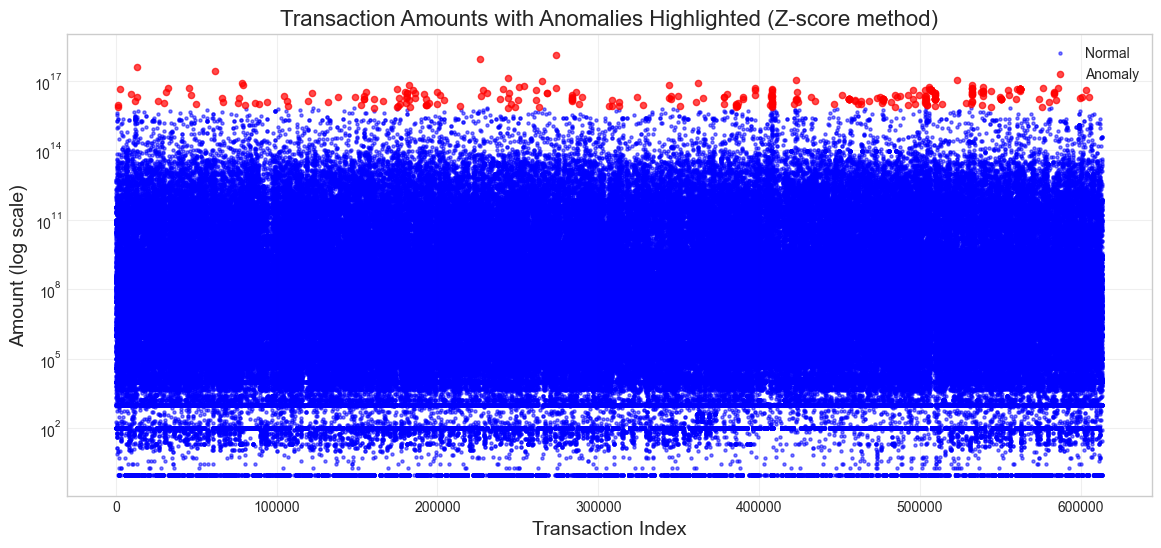

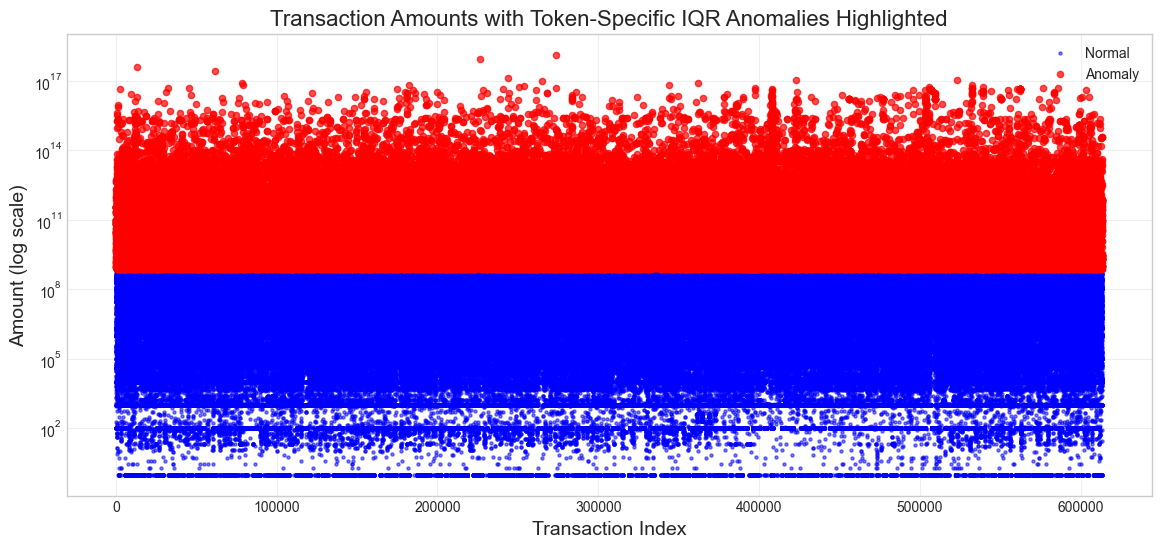

In [3]:
print("\n===== TRANSACTION-LEVEL ANOMALY DETECTION =====\n")
print("Applying statistical anomaly detection methods...\n")
# -----------------
# 1. Z-Score Method
mean_amount = df['amount'].mean()
std_amount = df['amount'].std()
df['z_score'] = (df['amount'] - mean_amount) / std_amount
# -----------------

# -----------------
# 2. IQR Method
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 2 * IQR
upper_bound = Q3 + 2 * IQR
# -----------------
# Flag anomalies using both methods
df['is_zscore_anomaly'] = abs(df['z_score']) > 3  # Standard 3-sigma rule
df['is_iqr_anomaly'] = (df['amount'] < lower_bound) | (df['amount'] > upper_bound)
# -----------------
# Count anomalies found by each method
z_anomaly_count = df['is_zscore_anomaly'].sum()
iqr_anomaly_count = df['is_iqr_anomaly'].sum()
both_anomaly_count = (df['is_zscore_anomaly'] & df['is_iqr_anomaly']).sum()

print(f"Anomalies detected using Z-score (|z| > 3): {z_anomaly_count:,} ({z_anomaly_count/len(df):.2%} of transactions)")
print(f"Anomalies detected using IQR method: {iqr_anomaly_count:,} ({iqr_anomaly_count/len(df):.2%} of transactions)")
print(f"Anomalies detected by both methods: {both_anomaly_count:,} ({both_anomaly_count/len(df):.2%} of transactions)")

# Display top anomalies by amount
print("\nTop 10 anomalous transactions by amount:")
display(df[df['is_zscore_anomaly']].sort_values('amount', ascending=False).head(10)[
    ['sender', 'recipient', 'amount', 'token', 'height', 'z_score']
])

# Visualize anomalies
plt.figure(figsize=(14, 6))
plt.scatter(
    df[~df['is_zscore_anomaly']].index, 
    df[~df['is_zscore_anomaly']]['amount'],
    alpha=0.5, s=5, c='blue', label='Normal'
)
plt.scatter(
    df[df['is_zscore_anomaly']].index, 
    df[df['is_zscore_anomaly']]['amount'],
    alpha=0.7, s=20, c='red', label='Anomaly'
)
plt.yscale('log')
plt.title('Transaction Amounts with Anomalies Highlighted (Z-score method)')
plt.xlabel('Transaction Index')
plt.ylabel('Amount (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Visualize anomalies (transaction amounts) using IQR method
plt.figure(figsize=(14, 6))
plt.scatter(
    df[~df['is_iqr_anomaly']].index, 
    df[~df['is_iqr_anomaly']]['amount'],
    alpha=0.5, s=5, c='blue', label='Normal'
)
plt.scatter(
    df[df['is_iqr_anomaly']].index, 
    df[df['is_iqr_anomaly']]['amount'],
    alpha=0.7, s=20, c='red', label='Anomaly'
)
plt.yscale('log')
plt.title('Transaction Amounts with Token-Specific IQR Anomalies Highlighted')
plt.xlabel('Transaction Index')
plt.ylabel('Amount (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Token-Specific Anomaly Detection

Different tokens have different value distributions - a 1 BTC (82146 USD) transfer and a 1 SHIB (0.000014 USD) transfer represent vastly different values! To account for this, we need to consider token-specific anomalies.

A transaction might be normal for one token but anomalous for another. By analyzing each token separately, we can identify anomalies in a more contextually relevant way.

Note: We could use the method above (z-score method)to detect anomalies on the "fiat"-converted amounts, without the need to look a token-specific anomaly. To do so, we would convert all the tokens values to a fiat currency, like USD, but we need some API or service to do that (which I haven't found yet). 

Calculating token-specific IQR anomalies...
Token-specific z-score anomalies detected: 3,227 (0.53% of all transactions)
Token-specific IQR anomalies detected: 92,129 (15.02% of all transactions)
Anomalies detected by both methods: 3,221 (0.53% of all transactions)


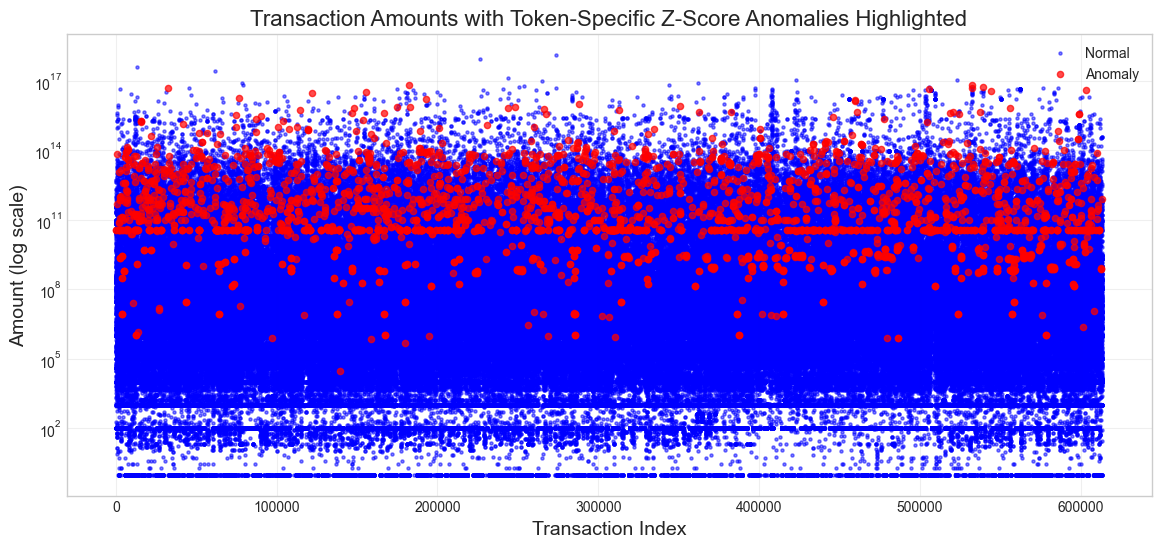

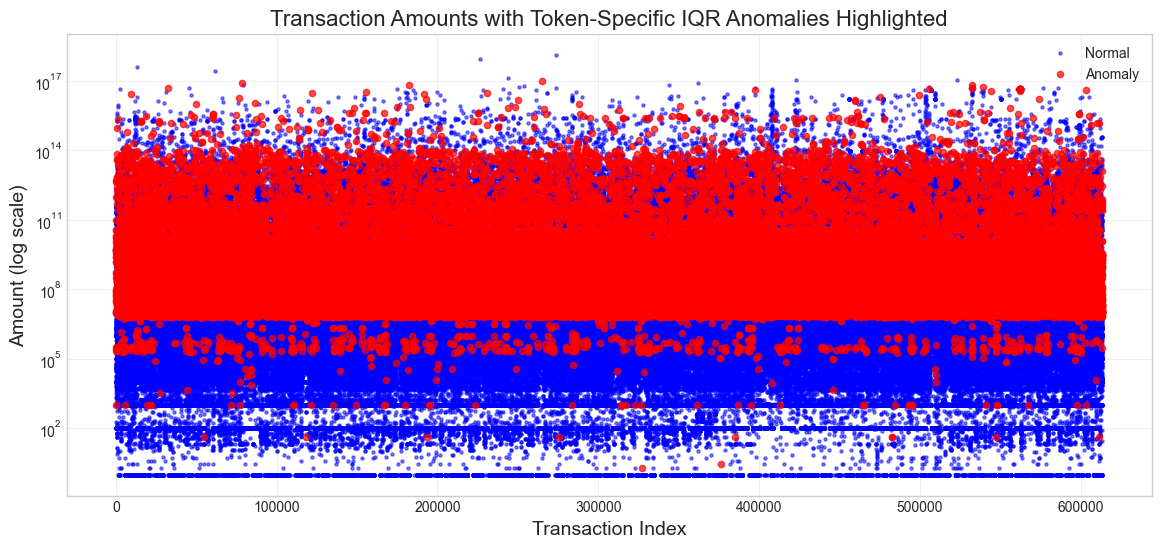


Examples of anomalous transactions detected by both methods:
                                              sender  \
44232   5sTQ5ih7xtctBhMXHr3f1aWdaXazWrWfoehqWdqWnTFP   
370606  CLmV9cax3iFZ97PuDhjbv7FtKB6BFszu5JQukaLTtUaS   
549112  GafNuUXj9rxGLn4y79dPu6MHSuPWeJR6UtTWuexpGh3U   
5510    14gKrPfvpZ21qS1tgNjjPFPAsSspwKi3T7RdyCF9o1PF   
261017  GafNuUXj9rxGLn4y79dPu6MHSuPWeJR6UtTWuexpGh3U   
261022  EofTP4AxD7d8nxT5EkZT93VaYAbn3uDyZmATdtkMzt2p   
370601  GafNuUXj9rxGLn4y79dPu6MHSuPWeJR6UtTWuexpGh3U   
405720  AqStYsgivG76ZcbVWVKR1zLBe2Np4FqE7gCBZwGnHszP   
549117   ywa5AuJ7ZvSed3X7qSYodzXfrdPnPcBzQS1mENRpDxN   
5505    GafNuUXj9rxGLn4y79dPu6MHSuPWeJR6UtTWuexpGh3U   

                                           recipient        amount  \
44232   3ADzk5YDP9sgorvPSs9YPxigJiSqhgddpwHwwPwmEFib  1.611600e+13   
370606  9DrvZvyWh1HuAoZxvYWMvkf2XCzryCpGgHqrMjyDWpmo  5.000000e+13   
549112  66PhzEYjV6YQTddgof8kTF4EazgycsTfmAZhavnZHwqt  5.000000e+13   
5510    9DrvZvyWh1HuAoZxvYWMvkf2XCzryCpGg

In [4]:
# Group transactions by token
token_groups = df.groupby('token')
# -----------------
# -----------------
# Calculate mean and standard deviation for each token
df['token_amount_mean'] = df['token'].map(token_groups['amount'].mean())
df['token_amount_std'] = df['token'].map(token_groups['amount'].std())

# Handle tokens with only one transaction (std = 0)
df['token_amount_std'] = df['token_amount_std'].replace(0, 1)

# Calculate z-score for each transaction relative to its token's distribution
df['token_z_score'] = (df['amount'] - df['token_amount_mean']) / df['token_amount_std']

# Step 2: Identify anomalies based on z-score
# Transactions with absolute z-score > 3 are considered anomalies
threshold = 3
df['is_zscore_anomaly'] = df['token_z_score'].abs() > threshold
# -----------------
# -----------------
# Step 2b: Calculate IQR-based anomalies for each token
print("Calculating token-specific IQR anomalies...")
# Initialize a Series to store the IQR anomaly flag
df['is_iqr_anomaly'] = False

# Store IQR boundaries for each token
token_iqr_data = {}

# Calculate IQR for each token and flag anomalies
for token, group in token_groups:
    Q1 = group['amount'].quantile(0.25)
    Q3 = group['amount'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    
    # Store the IQR data for this token
    token_iqr_data[token] = {
        'Q1': Q1,
        'Q3': Q3,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    
    # Flag anomalies for this token
    token_anomalies = (df['token'] == token) & ((df['amount'] < lower_bound) | (df['amount'] > upper_bound))
    df.loc[token_anomalies, 'is_iqr_anomaly'] = True

# Count and display summary of anomalies
zscore_anomaly_count = df['is_zscore_anomaly'].sum()
iqr_anomaly_count = df['is_iqr_anomaly'].sum()
both_anomaly_count = (df['is_zscore_anomaly'] & df['is_iqr_anomaly']).sum()

print(f"Token-specific z-score anomalies detected: {zscore_anomaly_count:,} ({zscore_anomaly_count/len(df):.2%} of all transactions)")
print(f"Token-specific IQR anomalies detected: {iqr_anomaly_count:,} ({iqr_anomaly_count/len(df):.2%} of all transactions)")
print(f"Anomalies detected by both methods: {both_anomaly_count:,} ({both_anomaly_count/len(df):.2%} of all transactions)")

# Step 3: Visualize anomalies (transaction amounts) using Z-score method
plt.figure(figsize=(14, 6))
plt.scatter(
    df[~df['is_zscore_anomaly']].index, 
    df[~df['is_zscore_anomaly']]['amount'],
    alpha=0.5, s=5, c='blue', label='Normal'
)
plt.scatter(
    df[df['is_zscore_anomaly']].index, 
    df[df['is_zscore_anomaly']]['amount'],
    alpha=0.7, s=20, c='red', label='Anomaly'
)
plt.yscale('log')
plt.title('Transaction Amounts with Token-Specific Z-Score Anomalies Highlighted')
plt.xlabel('Transaction Index')
plt.ylabel('Amount (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Step 3b: Visualize anomalies (transaction amounts) using IQR method
plt.figure(figsize=(14, 6))
plt.scatter(
    df[~df['is_iqr_anomaly']].index, 
    df[~df['is_iqr_anomaly']]['amount'],
    alpha=0.5, s=5, c='blue', label='Normal'
)
plt.scatter(
    df[df['is_iqr_anomaly']].index, 
    df[df['is_iqr_anomaly']]['amount'],
    alpha=0.7, s=20, c='red', label='Anomaly'
)
plt.yscale('log')
plt.title('Transaction Amounts with Token-Specific IQR Anomalies Highlighted')
plt.xlabel('Transaction Index')
plt.ylabel('Amount (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# Step 6: Display some examples of anomalous transactions
print("\nExamples of anomalous transactions detected by both methods:")
both_anomalies = df[df['is_zscore_anomaly'] & df['is_iqr_anomaly']].sort_values('token_z_score', ascending=False).head(10)
display_cols = ['sender', 'recipient', 'amount', 'token', 'token_z_score']
if all(col in df.columns for col in display_cols):
    print(both_anomalies[display_cols])
else:
    print(both_anomalies[['amount', 'token', 'token_z_score']])

### Temporal Anomaly Detection [not implemented]

Temporal anomalies occur when blockchain activity deviates significantly from normal patterns over time. These can indicate coordinated events, market reactions, network issues, or other significant occurrences.

Examples include:
- Sudden spikes in transaction volume or count
- Unusual activity during atypical hours
- Periodic patterns that deviate from normal cycles

We could  analyze temporal patterns at the blockchain level by examining transaction activity over time, using techniques like:
1. Rolling window statistics (and Z-score analysis)
3. Detection of unusual bursts of activity

## Transaction-Level Anomaly Detection: Machine Learning Methods

Statistical methods are effective for simple outlier detection, but they often miss more subtle anomalies that involve multiple features or complex relationships. Machine learning methods can help us detect these more complex patterns.

We'll use here **Isolation Forest**, an algorithm specifically designed for anomaly detection. It works by isolating observations by randomly selecting a feature and then randomly selecting a split value for the feature. Anomalies require fewer splits to be isolated, giving them a measurable anomaly score.

Unlike statistical methods that look at individual features, Isolation Forest can consider multiple features simultaneously, allowing it to detect anomalies that might appear normal when looking at each feature individually.


===== MACHINE LEARNING FOR TRANSACTION ANOMALY DETECTION =====

Running Isolation Forest for transaction anomaly detection...

Anomalies detected by Isolation Forest: 30,659 (5.00% of transactions)

Comparison of anomaly detection methods:
- Z-score only: 2,482 transactions
- Isolation Forest only: 29,914 transactions
- Both methods: 745 transactions

Top anomalies detected by Isolation Forest (sorted by anomaly score):


,sender,recipient,amount,token,height,if_raw_score
601979,6gbzTKydQe7qD1FdyKfeokSPF1gnJFmRPK82nN413CZ6,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.749409e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666731,-0.396746
590527,BBAJGv9K9hQB9zHmgwKch9jcn1tvUed8srsEHoin4zKh,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.651702e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666717,-0.396746
589226,FEJyET6HfVN3DaR5zzXx4LPJU5AhHvvovA9shV3donBZ,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.818352e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666715,-0.396746
586969,4PzAr3oCLRycxgKiUAXGNhrenyG8y5xdHhsJmQcXXDxQ,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.877699e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666714,-0.396746
579442,GSSVaUDWai3iSc1zXewQ1WgRipcGUAnUDji1CEBYgDzC,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.745527e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666706,-0.395599
459946,EB77TcfUjJEZjLP6e3LibS5rNN6Vgu6dW8hWC3tF2umM,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.396749e+16,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666572,-0.395024
544946,4PzAr3oCLRycxgKiUAXGNhrenyG8y5xdHhsJmQcXXDxQ,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,2.052501e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666665,-0.392646
546079,GSSVaUDWai3iSc1zXewQ1WgRipcGUAnUDji1CEBYgDzC,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.957732e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666666,-0.392646
547226,FEJyET6HfVN3DaR5zzXx4LPJU5AhHvvovA9shV3donBZ,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,2.054925e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666668,-0.392646
504192,FEJyET6HfVN3DaR5zzXx4LPJU5AhHvvovA9shV3donBZ,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,1.955317e+15,3YPukssiQc1Au2GpjFuixyBw6Zea826AGddfMWZJ6ktW,295666621,-0.391527


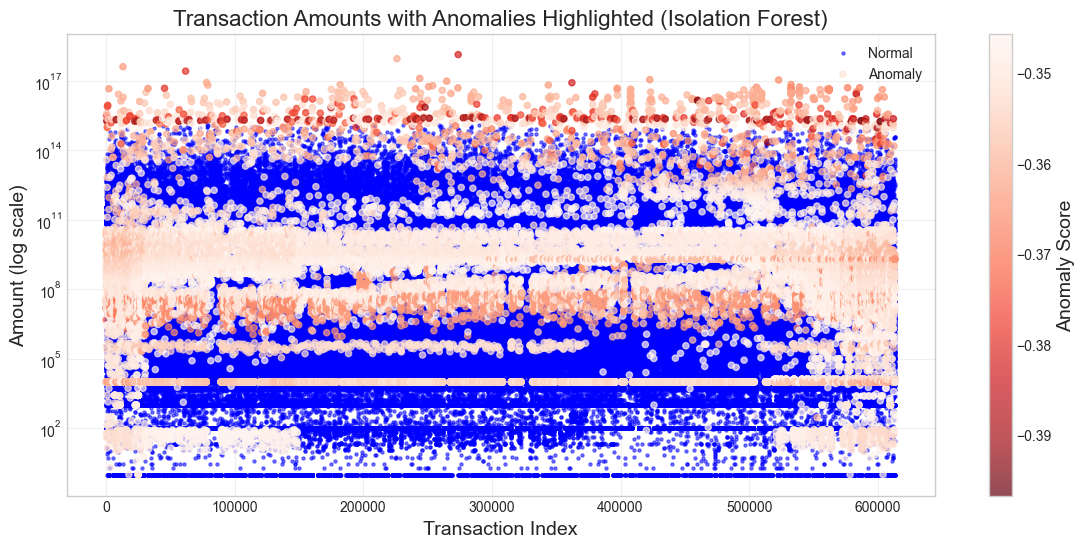

In [5]:
print("\n===== MACHINE LEARNING FOR TRANSACTION ANOMALY DETECTION =====\n")

# Apply Isolation Forest
print("Running Isolation Forest for transaction anomaly detection...\n")

# Start with numerical features
numerical_features = df[['amount', 'height']]

# Handle categorical features - tokens appear to have lower cardinality
# One-hot encode the token column
token_encoded = pd.get_dummies(df['token'], prefix='token')

# For high-cardinality categorical columns (sender/recipient addresses)
# Create frequency-based features which are more informative than direct encoding
sender_counts = df['sender'].value_counts().to_dict()
recipient_counts = df['recipient'].value_counts().to_dict()

df['sender_frequency'] = df['sender'].map(sender_counts)
df['recipient_frequency'] = df['recipient'].map(recipient_counts)

# Combine all features
transaction_features = pd.concat([
    numerical_features,
    token_encoded,
    df[['sender_frequency', 'recipient_frequency']]
], axis=1)

# Scale all numerical features (including the frequency features)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(transaction_features.fillna(0))
# -----------------
# -----------------
# Fit Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  
    random_state=42
)
# -----------------
# -----------------
# Fit and predict anomaly scores (-1 for anomalies, 1 for normal points)
df['if_anomaly_score'] = iso_forest.fit_predict(scaled_features)
df['is_if_anomaly'] = df['if_anomaly_score'] == -1

# Get raw anomaly scores (negative scores indicate stronger anomalies)
raw_scores = iso_forest.score_samples(scaled_features)
df['if_raw_score'] = raw_scores
# -----------------
# -----------------
# Count anomalies detected by Isolation Forest
if_anomaly_count = (df['is_if_anomaly']).sum()
print(f"Anomalies detected by Isolation Forest: {if_anomaly_count:,} ({if_anomaly_count/len(df):.2%} of transactions)")

# Compare anomalies detected by different methods
print("\nComparison of anomaly detection methods:")
print(f"- Z-score only: {(df['is_zscore_anomaly'] & ~df['is_if_anomaly']).sum():,} transactions")
print(f"- Isolation Forest only: {(~df['is_zscore_anomaly'] & df['is_if_anomaly']).sum():,} transactions")
print(f"- Both methods: {(df['is_zscore_anomaly'] & df['is_if_anomaly']).sum():,} transactions")

# Display top anomalies detected by Isolation Forest, sorted by anomaly score
print("\nTop anomalies detected by Isolation Forest (sorted by anomaly score):")
display(df[df['is_if_anomaly']].sort_values('if_raw_score').head(10)[
    ['sender', 'recipient', 'amount', 'token', 'height', 'if_raw_score']
])

# Visualize anomalies detected by Isolation Forest
plt.figure(figsize=(14, 6))

# Plot normal points
plt.scatter(
    df[~df['is_if_anomaly']].index, 
    df[~df['is_if_anomaly']]['amount'],
    alpha=0.5, s=5, c='blue', label='Normal'
)

# Plot anomalies with color intensity based on anomaly score
anomalies = df[df['is_if_anomaly']]
plt.scatter(
    anomalies.index,
    anomalies['amount'],
    alpha=0.7, s=20,
    c=anomalies['if_raw_score'],
    cmap='Reds_r',  # Reversed red colormap - more negative scores = darker red
    label='Anomaly'
)
plt.colorbar(label='Anomaly Score')

plt.yscale('log')
plt.title('Transaction Amounts with Anomalies Highlighted (Isolation Forest)')
plt.xlabel('Transaction Index')
plt.ylabel('Amount (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Address-Level Anomaly Detection

While individual transaction anomalies are important, they only tell part of the story. Address-level anomalies focus on the behavior of blockchain addresses over time.

An address's activity profile - how often it transacts, its typical volumes, who it interacts with - forms a behavioral signature. Sudden changes in this signature could indicate compromise, fraud, or other significant events.

For example:
- A dormant address suddenly becoming very active
- An address that typically sends small amounts suddenly transferring large sums
- An address with few counterparties suddenly interacting with many new addresses

To detect these patterns, we first need to extract comprehensive features for each address in our dataset.

In [6]:
print("\n===== ADDRESS-LEVEL ANOMALY DETECTION =====\n")
from feature_extraction import extract_features
# Extract features for all addresses
print("Extracting features for all addresses...")
# -----------------
# -----------------
address_features = extract_features(df)
# -----------------
# -----------------
print(f"Extracted features for {len(address_features)} addresses")
print("\nSample of address features:")
display(address_features.head())


===== ADDRESS-LEVEL ANOMALY DETECTION =====

Extracting features for all addresses...
Starting feature extraction process...
Computing sender metrics...
Computing recipient metrics...
Merging sender and recipient metrics...
Computing derived metrics...
Building transaction network graph...
Computing network centrality metrics...
Finalizing feature extraction...
Extracted features for 172697 addresses
Extracted features for 172697 addresses

Sample of address features:


,tx_count_out,volume_out,value_max_out,value_min_out,value_avg_out,value_median_out,value_p25_out,value_p75_out,value_p90_out,value_std_out,...,volume_total,volume_net,value_min,value_max,time_first_height,time_last_height,time_duration_blocks,network_degree,network_in_degree,network_out_degree
address,,,,,,,,,,,,,,,,,,,,,
11111111111111111111111111111111,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.840020e+11,2.840020e+11,0.0,1.071268e+11,0.0,295666741.0,295666741.0,0.000006,0.000006,0.000000
11CFe3GWVF29T1ppPsJeSRc3Luhg5E9FUM1qVEGGrCX,1.0,2.039280e+06,2.039280e+06,2.039280e+06,2.039280e+06,2.039280e+06,2.039280e+06,2.039280e+06,2.039280e+06,0.000000e+00,...,2.039280e+06,-2.039280e+06,0.0,2.039280e+06,0.0,295666270.0,295666270.0,0.000006,0.000000,0.000006
1212UMAW7zdJiKshVfs2ZktxdRoUkhmdBuTHQPUQ8PbL,3.0,8.794638e+06,5.000000e+06,1.755358e+06,2.931546e+06,2.039280e+06,1.897319e+06,3.519640e+06,4.407856e+06,1.796950e+06,...,8.794838e+06,-8.794438e+06,100.0,5.000000e+06,295666453.0,295666462.0,9.0,0.000029,0.000012,0.000017
121F7kKnbD1oHBE5i1qeJ4GNDGa96K9DQPc946aiiR2w,1.0,2.629705e+11,2.629705e+11,2.629705e+11,2.629705e+11,2.629705e+11,2.629705e+11,2.629705e+11,2.629705e+11,0.000000e+00,...,2.629726e+11,-2.629685e+11,2039280.0,2.629705e+11,295666603.0,295666632.0,29.0,0.000012,0.000006,0.000006
121PE6e6SRFEr5iFCTmsNXdPbcSN2DAaGP7W4CQ9bwM5,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,1.693227e+07,1.693227e+07,0.0,1.489299e+07,0.0,295666638.0,295666638.0,0.000012,0.000012,0.000000


In [7]:
print(address_features.columns)

Index(['tx_count_out', 'volume_out', 'value_max_out', 'value_min_out',
       'value_avg_out', 'value_median_out', 'value_p25_out', 'value_p75_out',
       'value_p90_out', 'value_std_out', 'time_first_height_out',
       'time_last_height_out', 'time_height_range_out', 'token_unique_out',
       'counter_unique_recipients', 'tx_hash_unique_out', 'block_unique_out',
       'tx_count_in', 'volume_in', 'value_max_in', 'value_min_in',
       'value_avg_in', 'value_median_in', 'value_p25_in', 'value_p75_in',
       'value_p90_in', 'value_std_in', 'time_first_height_in',
       'time_last_height_in', 'time_height_range_in', 'token_unique_in',
       'counter_unique_senders', 'tx_hash_unique_in', 'block_unique_in',
       'tx_count_total', 'volume_total', 'volume_net', 'value_min',
       'value_max', 'time_first_height', 'time_last_height',
       'time_duration_blocks', 'network_degree', 'network_in_degree',
       'network_out_degree'],
      dtype='object')


### Preprocessing Features

Same as for the address clustering, we need to preprocess our features to:
1. Handle missing values
2. Select relevant features
3. Scale the features

In [8]:
# Check for NaN and inf values
print("Checking for NaN and infinite values...")
nan_counts = address_features.isna().sum()
inf_counts = address_features.isin([np.inf, -np.inf]).sum()

# Display columns with issues
print("\nColumns with NaN values:")
display(nan_counts[nan_counts > 0])
print("\nColumns with infinite values:")
display(inf_counts[inf_counts > 0])

# Fill NaN values with 0 and replace inf with large values
address_features.fillna(0, inplace=True)
address_features.replace([np.inf, -np.inf], 1e6, inplace=True)

Checking for NaN and infinite values...

Columns with NaN values:


Series([], dtype: int64)


Columns with infinite values:


Series([], dtype: int64)

In [9]:
# Select features for clustering [we select all here, but we could select only the most relevant ones]
feature_cols = [
    'tx_count_in', 'tx_count_out', 'tx_count_total', # Transaction counts
    'volume_in', 'volume_out', 'volume_total', 'volume_net', # Volume metrics
    'value_avg_in', 'value_avg_out', 'value_max', 'value_min', # Transaction values
    'value_std_in', 'value_std_out',  # Transaction values
    'time_duration_blocks', 'time_height_range_in', 'time_height_range_out', # Time features
    'counter_unique_senders', 'counter_unique_recipients', # Diversity metrics
    'token_unique_in', 'token_unique_out', # Diversity metrics
    'network_degree', 'network_in_degree', 'network_out_degree'  # Network metrics
]

# Ensure all selected features exist
feature_cols = [f for f in feature_cols if f in address_features.columns]
print(f"Selected {len(feature_cols)} features for clustering")

# Extract feature matrix
X = address_features[feature_cols].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Selected 23 features for clustering


### Detecting Anomalous Addresses with Isolation Forest

Now that we have comprehensive features for each address, we can use machine learning to identify addresses with unusual behavioral patterns.

We'll again use the Isolation Forest algorithm, but this time at the address level. This will help us identify addresses that have unusual combinations of features - for example, addresses with an unusual ratio of incoming to outgoing transactions, or addresses with abnormally high volume relative to their transaction count.

Such anomalies could indicate:
- Potential money laundering (unusual patterns of funds flowing in and out)
- Exchange or mixer services (high connectivity with many other addresses)
- Compromised wallets (sudden changes in transaction patterns)
- Scam or fraud operations (unusual distribution patterns)


Applying Isolation Forest for address-level anomaly detection...

Running Isolation Forest to detect anomalous addresses...
Detected 8635 anomalous addresses (5.00% of all addresses)

Top 10 anomalous addresses by transaction count:


,address,tx_count_total,volume_total,raw_anomaly_score,total_counterparties
0,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,63978.0,2.588977e+18,-0.305901,32101.0
1,Habp5bncMSsBC3vkChyebepym5dcTNRYeg2LVG464E96,30358.0,3.035800e+06,-0.162627,19762.0
2,fLiPgg2yTvmgfhiPkKriAHkDmmXGP6CdeFX9UF5o7Zc,29861.0,2.986100e+06,-0.162627,19746.0
3,DBTMopiGE3CxumsfTNVYmL1a5eaw5H1iyaE3XzmozxRU,20063.0,3.383155e+10,-0.236894,8603.0
4,Mt7CZJFn2ZmDvMb2dBBcs3KGfXGJqUz6grsvtwxEnkP,19620.0,3.264553e+11,-0.237908,7496.0
5,CebN5WGQ4jvEPvsVU4EoHEpgzq1VV7AbicfhtW4xC9iM,11874.0,3.961309e+10,-0.162653,5636.0
6,De75MLmkwh9j5tTjEYf8cQsrnUYGfRRbTMzRLYj7wigM,11460.0,7.866450e+09,-0.191592,957.0
7,pigVv65eXGHGXdcZHQCR8iDpqdAeccpEqgCifxuyGQt,11243.0,1.124300e+04,-0.162627,5579.0
8,7X1JjurgNGXqSChFiUA19bmzbfWxJrwMDqa9LyCicArU,11208.0,7.693470e+09,-0.157798,13.0
9,3AVi9Tg9Uo68tJfuvoKvqKNWKkC5wPdSSdeBnizKZ6jT,9595.0,1.988157e+10,-0.162653,3099.0



Top 10 anomalous addresses by volume:


,address,tx_count_total,volume_total,raw_anomaly_score,total_counterparties
0,5Q544fKrFoe6tsEbD7S8EmxGTJYAKtTVhAW5Q5pge4j1,63978.0,2.588977e+18,-0.305901,32101.0
1,GFeb7eL4nfMJ1fnQtwJj3pk1cEG1u5fsqocKV46vwgwk,160.0,1.680818e+18,-0.297095,160.0
2,HFxqBth4nwsZCBuyJLSiFQCWNTFpN4xGjzGEkp8PyYMA,1.0,1.352708e+18,-0.166760,1.0
3,GpMZbSM2GgvTKHJirzeGfMFoaZ8UR2X7F4v8vHTvxFbL,4992.0,9.820964e+17,-0.309228,1194.0
4,6cm6GNDt8CJu3itZrYdXzHamsg59vJNkcZX7E4mfR3qX,1.0,9.000000e+17,-0.166760,1.0
5,C5rA8AJLuyBKems2rhAV5C7HFsuGa4feTakChYa2GUC4,1.0,9.000000e+17,-0.172262,1.0
6,6q8LKHdpjD49RMfaPFAbt5H79nzZbGJv3g4pQdWAJUFT,83.0,6.942118e+17,-0.299288,66.0
7,2WDKYpM7iKqk3ndsAWHwrofnSoWMfw8vc7ATqmfRMeGd,15.0,5.983500e+17,-0.221443,15.0
8,D9u3VnY19r1ZL6AM3KkUaUDnxtj8FSGAhLhMHD1QZAft,32.0,5.120000e+17,-0.241787,25.0
9,CsCL285E8bj2iyirnZhdkTtH3oZzHxokBJbv6WwivgdJ,35.0,4.657295e+17,-0.314901,16.0


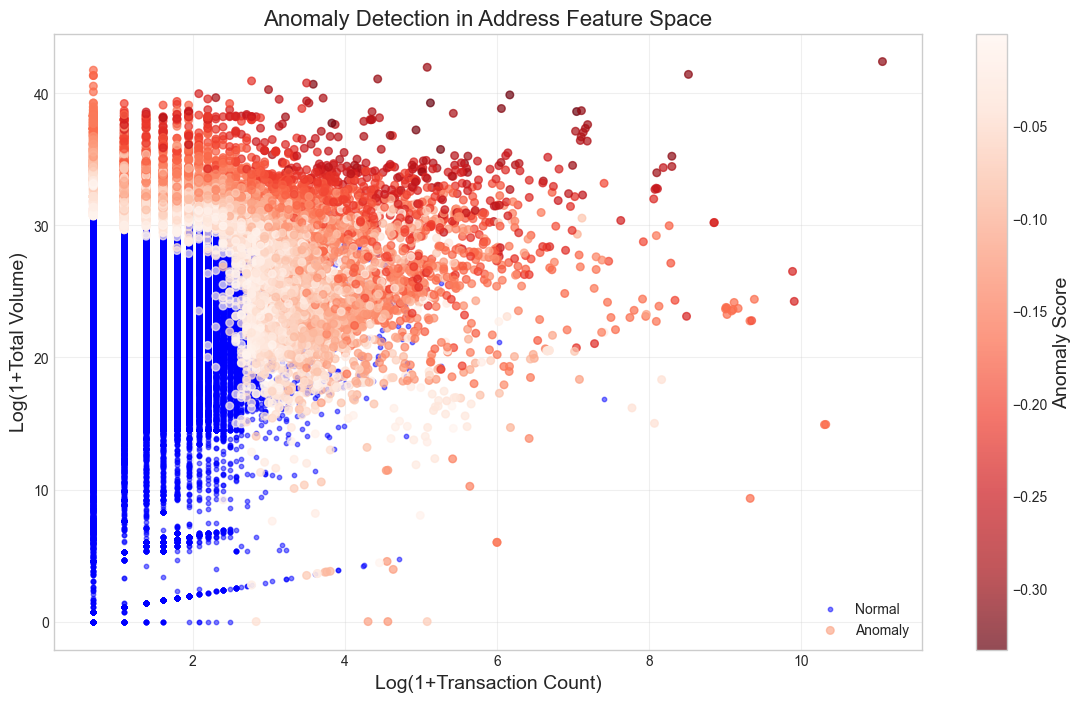

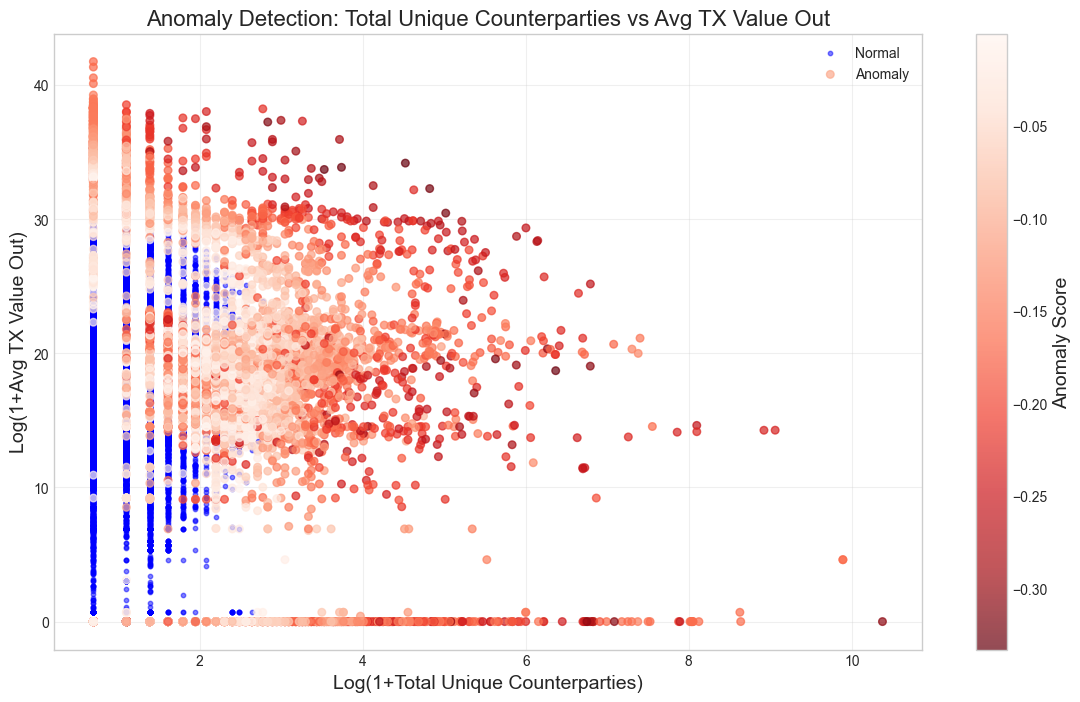

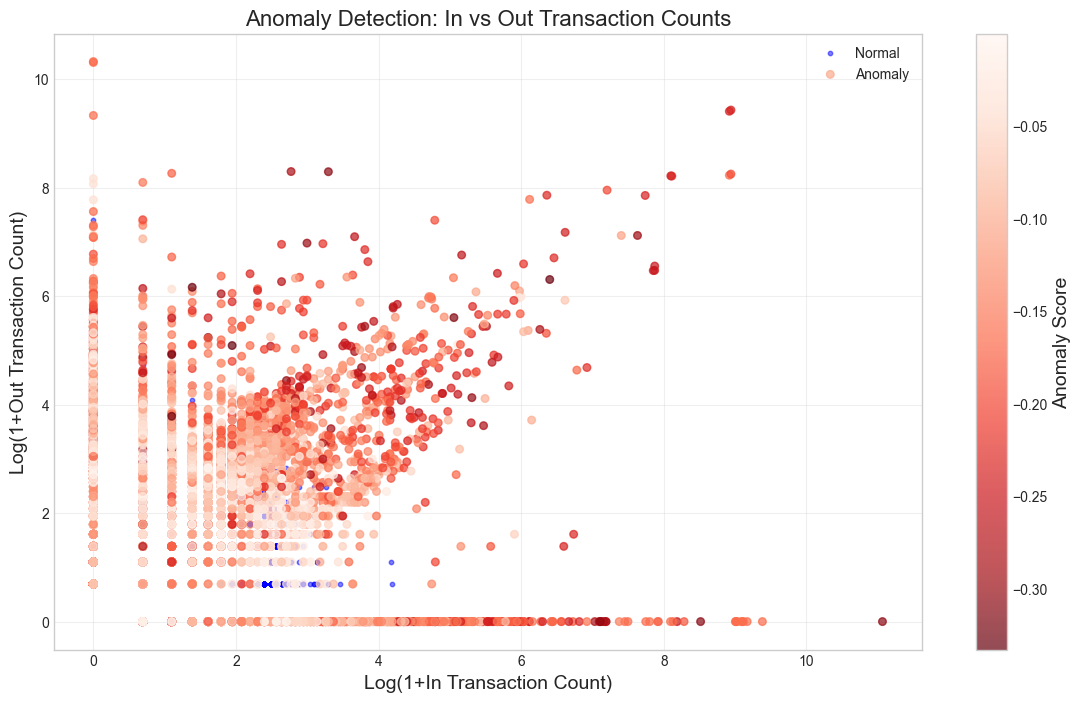


Analyzing most anomalous addresses:

Feature values for top 5 most anomalous addresses:


,address,tx_count_in,tx_count_out,volume_in,volume_out,raw_anomaly_score,total_counterparties
0,DEHG7Vd8BPZsnTn8gM1NRU8TpJUFwRYRCXYcpYZsVgfr,6.0,161.0,8.844327e+14,1.124724e+17,-0.332999,91.0
1,AtTjQKXo1CYTa2MuxPARtr382ZyhPU5YX4wMMpvaa1oy,601.0,546.0,5.886027e+16,7.257555e+10,-0.329006,581.0
2,G6VaXpCYxe2GPKy7rtZptVhod2YtPpcfxBB5johLedwq,3.0,473.0,2.099543e+15,2.056772e+17,-0.328437,33.0
3,HPqaWv9aNcQ94y71tdXK4Vgk35XjUdwYGchiB65KggDa,2.0,43.0,2.642380e+15,2.194069e+16,-0.325599,41.0
4,GxoDZK5YrBhorv96cQZfn8D93kBwNQnLan97ZDs963yB,2.0,136.0,3.871255e+14,1.421722e+16,-0.322206,123.0



Features that make these addresses anomalous (ratio to average):

Address: DEHG7Vd8BPZsnTn8gM1NRU8TpJUFwRYRCXYcpYZsVgfr (Anomaly Score: -0.3330)
  - volume_out: 146954.98x average (higher)
  - volume_total: 117699.58x average (higher)
  - value_std_out: 73327.89x average (higher)
  - value_max: 6257.86x average (higher)
  - volume_in: 4472.47x average (higher)

Address: AtTjQKXo1CYTa2MuxPARtr382ZyhPU5YX4wMMpvaa1oy (Anomaly Score: -0.3290)
  - volume_in: 297649.29x average (higher)
  - volume_total: 61115.29x average (higher)
  - value_max: 31996.55x average (higher)
  - value_std_in: 26948.76x average (higher)
  - value_avg_in: 780.19x average (higher)

Address: G6VaXpCYxe2GPKy7rtZptVhod2YtPpcfxBB5johLedwq (Anomaly Score: -0.3284)
  - volume_out: 268735.07x average (higher)
  - volume_total: 215736.68x average (higher)
  - value_std_out: 97164.04x average (higher)
  - value_max: 16269.26x average (higher)
  - volume_in: 10617.13x average (higher)

Address: HPqaWv9aNcQ94y71tdXK4Vgk35Xj

In [10]:
print("\nApplying Isolation Forest for address-level anomaly detection...\n")

# Run Isolation Forest for anomaly detection
print("Running Isolation Forest to detect anomalous addresses...")
# -----------------
# -----------------
isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Expect about 5% anomalies
    random_state=42
)
# -----------------
# -----------------
# Get anomaly labels (-1 for anomalies, 1 for normal points)
address_features['anomaly_score'] = isolation_forest.fit_predict(X_scaled)
# Get raw anomaly scores (negative numbers where more negative = more anomalous)
address_features['raw_anomaly_score'] = isolation_forest.decision_function(X_scaled)
# Convert labels to boolean
address_features['is_anomaly'] = address_features['anomaly_score'] == -1
# -----------------
# -----------------
# Count anomalies
anomaly_count = address_features['is_anomaly'].sum()
print(f"Detected {anomaly_count} anomalous addresses ({anomaly_count/len(address_features):.2%} of all addresses)")

# Examine the anomalous addresses
anomalous_addresses = address_features[address_features['is_anomaly']]

# Create DataFrames for display with the index reset
display_df_tx = anomalous_addresses.sort_values('tx_count_total', ascending=False).head(10).reset_index()
display_df_vol = anomalous_addresses.sort_values('volume_total', ascending=False).head(10).reset_index()

# Create a total counterparties column from the sum of senders and recipients
if 'counter_unique_senders' in display_df_tx.columns and 'counter_unique_recipients' in display_df_tx.columns:
    display_df_tx['total_counterparties'] = display_df_tx['counter_unique_senders'] + display_df_tx['counter_unique_recipients']
    display_df_vol['total_counterparties'] = display_df_vol['counter_unique_senders'] + display_df_vol['counter_unique_recipients']

# Get the actual name of the index column after reset_index()
index_col_name = display_df_tx.columns[0]  # The first column will be the former index

# Display top anomalies by transaction count
print("\nTop 10 anomalous addresses by transaction count:")
columns_to_display = [index_col_name, 'tx_count_total', 'volume_total', 'raw_anomaly_score']
if 'total_counterparties' in display_df_tx.columns:
    columns_to_display.append('total_counterparties')
display(display_df_tx[columns_to_display])

# Display top anomalies by volume
print("\nTop 10 anomalous addresses by volume:")
display(display_df_vol[columns_to_display])

# Visualize anomalies in feature space - main plot
plt.figure(figsize=(14, 8))
plt.scatter(
    np.log1p(address_features[~address_features['is_anomaly']]['tx_count_total']),
    np.log1p(address_features[~address_features['is_anomaly']]['volume_total']),
    c='blue', alpha=0.5, s=10, label='Normal'
)
scatter = plt.scatter(
    np.log1p(address_features[address_features['is_anomaly']]['tx_count_total']),
    np.log1p(address_features[address_features['is_anomaly']]['volume_total']),
    c=address_features[address_features['is_anomaly']]['raw_anomaly_score'],
    cmap='Reds_r', alpha=0.7, s=30, label='Anomaly'
)
plt.colorbar(scatter, label='Anomaly Score')
plt.title('Anomaly Detection in Address Feature Space')
plt.xlabel('Log(1+Transaction Count)')
plt.ylabel('Log(1+Total Volume)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Second visualization - using counter columns directly
plt.figure(figsize=(14, 8))
# Sum the counter columns
total_counterparties = address_features['counter_unique_senders'] + address_features['counter_unique_recipients']
plt.scatter(
    np.log1p(total_counterparties[~address_features['is_anomaly']]),
    np.log1p(address_features[~address_features['is_anomaly']]['value_avg_out']), 
    c='blue', alpha=0.5, s=10, label='Normal'
)
scatter = plt.scatter(
    np.log1p(total_counterparties[address_features['is_anomaly']]),
    np.log1p(address_features[address_features['is_anomaly']]['value_avg_out']),
    c=address_features[address_features['is_anomaly']]['raw_anomaly_score'],
    cmap='Reds_r', alpha=0.7, s=30, label='Anomaly'
)
plt.colorbar(scatter, label='Anomaly Score')
plt.title('Anomaly Detection: Total Unique Counterparties vs Avg TX Value Out')
plt.xlabel('Log(1+Total Unique Counterparties)')
plt.ylabel('Log(1+Avg TX Value Out)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Third visualization - in vs out transaction counts
plt.figure(figsize=(14, 8))
plt.scatter(
    np.log1p(address_features[~address_features['is_anomaly']]['tx_count_in']),
    np.log1p(address_features[~address_features['is_anomaly']]['tx_count_out']), 
    c='blue', alpha=0.5, s=10, label='Normal'
)
scatter = plt.scatter(
    np.log1p(address_features[address_features['is_anomaly']]['tx_count_in']),
    np.log1p(address_features[address_features['is_anomaly']]['tx_count_out']),
    c=address_features[address_features['is_anomaly']]['raw_anomaly_score'],
    cmap='Reds_r', alpha=0.7, s=30, label='Anomaly'
)
plt.colorbar(scatter, label='Anomaly Score')
plt.title('Anomaly Detection: In vs Out Transaction Counts')
plt.xlabel('Log(1+In Transaction Count)')
plt.ylabel('Log(1+Out Transaction Count)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Look at most anomalous addresses in detail
print("\nAnalyzing most anomalous addresses:")
# Get top 5 most anomalous addresses
top_anomalies = address_features.sort_values('raw_anomaly_score').head(5).reset_index()

# Display their feature values
print("\nFeature values for top 5 most anomalous addresses:")
# Use the same index column name
display_cols = [index_col_name, 'tx_count_in', 'tx_count_out', 'volume_in', 'volume_out', 'raw_anomaly_score']
if 'counter_unique_senders' in top_anomalies.columns and 'counter_unique_recipients' in top_anomalies.columns:
    top_anomalies['total_counterparties'] = top_anomalies['counter_unique_senders'] + top_anomalies['counter_unique_recipients']
    display_cols.append('total_counterparties')
display(top_anomalies[display_cols])

# Feature importance based on magnitude of difference from normal
print("\nFeatures that make these addresses anomalous (ratio to average):")
normal_means = address_features[~address_features['is_anomaly']][feature_cols].mean()

# For each anomalous address, show the top features that deviate most from normal
for idx, row in top_anomalies.iterrows():
    print(f"\nAddress: {row[index_col_name]} (Anomaly Score: {row['raw_anomaly_score']:.4f})")
    
    # Calculate ratios for all features
    ratios = {}
    for feature in feature_cols:
        if normal_means[feature] > 0:  # Avoid division by zero
            ratio = row[feature] / normal_means[feature]
            ratios[feature] = ratio
    
    # Sort and display the top 5 most deviating features
    sorted_features = sorted(ratios.items(), key=lambda x: abs(x[1]-1), reverse=True)[:5]
    for feature, ratio in sorted_features:
        print(f"  - {feature}: {ratio:.2f}x average " + 
              ("(higher)" if ratio > 1 else "(lower)"))

## Network Anomaly Detection [NOT IMPLEMENTED]

Blockchain transactions form a complex network where addresses are nodes and transactions are directed edges. Analyzing this network structure can reveal:

- Unusual transaction patterns between groups of addresses
- Addresses that suddenly become central to the network
- Communities of addresses with suspicious coordination

We could build a transaction graph and apply network analysis techniques to identify addresses that have anomalous positions or roles in the transaction network.

## Combining Multiple Anomaly Detection Methods

Each of our anomaly detection methods focused on different aspects of blockchain activity:

1. **Transaction-level anomalies**: Identified unusual individual transactions
2. **Address-level anomalies**: Detected addresses with suspicious behavior patterns

By combining these methods, we can get a more comprehensive view of suspicious activity in the blockchain. Entities that are flagged by multiple methods are especially worthy of investigation. We could create a combined anomaly score that takes into account all of these methods, by finding transactions/addresses with multiple types of anomalies.

## Conclusion and Insights

We've implemented a comprehensive anomaly detection system for blockchain transactions, combining multiple approaches:

1. **Statistical methods** (Z-score, IQR) can identify outliers in transaction values
2. **Machine learning** (Isolation Forest) can detect complex anomalies at both transaction and address levels

Some [not implemented] methods:

3. **Temporal analysis** can reveal unusual activity patterns over time
4. **Network analysis** can identify addresses with suspicious positions in the transaction graph.


### Implications for Blockchain Security:

These notebook demonstrate the power of a multi-faceted approach to anomaly detection in blockchain networks. Security teams at organizations like Range.org can use these techniques to:

1. Monitor for potential security incidents in real-time
2. Identify suspicious entities for further investigation
3. Detect emerging patterns of fraud or abuse
4. Improve understanding of normal vs. abnormal behavior on the blockchain

By continuing to refine these methods and incorporating additional data sources (such as known entity labels and cross-chain information), blockchain security teams can build increasingly sophisticated and effective anomaly detection systems.